In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import ttest_ind, pearsonr, spearmanr, chi2_contingency
from sklearn.preprocessing import StandardScaler
import sys

sys.path.append('../src')
from functions import *
# Raw Data
df_clients_profile = pd.read_csv('../Data/Raw/df_final_demo.txt')
df_web_data_1 = pd.read_csv('../Data/Raw/df_final_web_data_pt_1.txt')
df_web_data_2 = pd.read_csv('../Data/Raw/df_final_web_data_pt_2.txt')
df_experiment_clients = pd.read_csv('../Data/Raw/df_final_experiment_clients.txt')

# Load Data
df_test = pd.read_csv('../Data/Cleaned_Data/df_test.csv')
df_test_final = pd.read_csv('../Data/Cleaned_Data/df_test_final.csv')
df_control = pd.read_csv('../Data/Cleaned_Data/df_control.csv')
df_control_final = pd.read_csv('../Data/Cleaned_Data/df_control_final.csv')
df_final = pd.read_csv('../Data/Cleaned_Data/df_final.csv')
df_combined = pd.read_csv('../Data/Cleaned_Data/df_combined.csv')
pd.set_option('display.max_columns', None)

In [3]:
df_test = convert_data_types_combined(df_test)
df_test_final = convert_data_types_combined(df_test_final)
df_control = convert_data_types_combined(df_control)
df_control_final = convert_data_types_combined(df_control_final)
df_final = convert_data_types_combined(df_final)
df_combined = convert_data_types_combined(df_combined)


In [4]:
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Combining web data
df_web_data = pd.concat([df_web_data_1, df_web_data_2], ignore_index=True)

# Filter out visits with different visitor IDs
duplicate_visits = df_web_data.groupby('visit_id')['visitor_id'].nunique().gt(1)
visits_with_different_ids = duplicate_visits[duplicate_visits].index.tolist()
if visits_with_different_ids:
    print(f"Visit IDs with different visitor IDs: {visits_with_different_ids}")
else:
    print("No visit IDs with different visitor IDs found.")


No visit IDs with different visitor IDs found.


Completion Rate Test: 58.52324766984538%
Completion Rate Control: 49.839967682794196%


/tmp/ipykernel_114097/1060675312.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test = df_test.groupby('visit_id').apply(calculate_time_spent).reset_index(drop=True)
/tmp/ipykernel_114097/1060675312.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_control = df_control.groupby('visit_id').apply(calculate_time_spent).reset_index(drop=True)


Average Time Spent on Each Step (Test):
process_step
confirm   0 days 00:01:52.006027375
start     0 days 00:01:01.425175370
step_1    0 days 00:00:37.419528810
step_2    0 days 00:00:47.856995286
step_3    0 days 00:01:35.844792954
Name: time_spent, dtype: timedelta64[ns]

Average Time Spent on Each Step (Control):
process_step
confirm   0 days 00:02:03.036975654
start     0 days 00:00:53.518775347
step_1    0 days 00:00:42.568702161
step_2    0 days 00:00:38.521235073
step_3    0 days 00:01:32.256725325
Name: time_spent, dtype: timedelta64[ns]
Error Rate Test: 6.36%
Error Rate Control: 3.16%
Drop-Off Rate Test:
process_step
confirm   -52.561565
start      14.693459
step_1     13.372710
step_2      9.443514
step_3      2.051398
Name: visit_id, dtype: float64

Drop-Off Rate Control:
process_step
confirm   -92.674107
start      23.822930
step_1     14.485366
step_2      9.130197
step_3     12.321653
Name: visit_id, dtype: float64


/tmp/ipykernel_114097/1060675312.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drop_offs = users_reaching_step - users_reaching_step.shift(-1, fill_value=users_reaching_step[0])
/tmp/ipykernel_114097/1060675312.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drop_offs = users_reaching_step - users_reaching_step.shift(-1, fill_value=users_reaching_step[0])


<Figure size 1200x800 with 0 Axes>

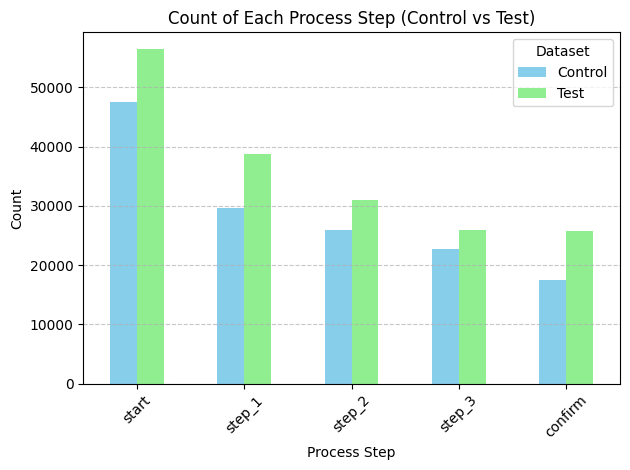

In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Define functions

def categorize_age(age):
    """Categorize age into groups."""
    if age < 20:
        return 'teen'
    elif 20 <= age < 30:
        return 'young adults'
    elif 30 <= age < 60:
        return 'middle-age adults'
    else:
        return 'senior'

def calculate_time_spent(group):
    """Calculate the average time spent on each process step."""
    group = group.sort_values('date_time')
    group['time_spent'] = group['date_time'].diff().fillna(pd.Timedelta(seconds=0))
    return group

def calculate_error_rate(df):
    """Calculate the error rate by detecting backward moves within a short time period."""
    df['time_diff'] = df.groupby('visit_id')['date_time'].diff().dt.total_seconds()
    df['backward_move'] = (df.groupby('visit_id')['process_step'].shift(1) > df['process_step']) & (df['time_diff'] < 5)
    backward_moves = df['backward_move'].sum()
    unique_visits = df['visit_id'].nunique()
    error_rate = (backward_moves / unique_visits * 100).round(2)
    return error_rate

def calculate_drop_off_rate(df):
    """Calculate the drop-off rate at each process step."""
    users_reaching_step = df.groupby('process_step')['visit_id'].nunique()
    drop_offs = users_reaching_step - users_reaching_step.shift(-1, fill_value=users_reaching_step[0])
    drop_off_rate = (drop_offs / users_reaching_step) * 100
    return drop_off_rate

# Assuming these data frames are already available
# df_test, df_test_final, df_control, df_control_final, df_final, df_combined

# Ensure date_time is in datetime format
df_test['date_time'] = pd.to_datetime(df_test['date_time'], errors='coerce')
df_control['date_time'] = pd.to_datetime(df_control['date_time'], errors='coerce')

# Check for any rows where date_time conversion failed
if df_test['date_time'].isna().any() or df_control['date_time'].isna().any():
    print("Warning: Some date_time values could not be converted. These rows will be dropped.")
    df_test = df_test.dropna(subset=['date_time'])
    df_control = df_control.dropna(subset=['date_time'])

# Calculate completion rate
completion_rate_test = df_test[df_test['process_step'] == 'confirm']['visit_id'].nunique() / df_test['visit_id'].nunique() * 100
completion_rate_control = df_control[df_control['process_step'] == 'confirm']['visit_id'].nunique() / df_control['visit_id'].nunique() * 100

print(f"Completion Rate Test: {completion_rate_test}%")
print(f"Completion Rate Control: {completion_rate_control}%")

# Calculate time spent on each step
df_test = df_test.groupby('visit_id').apply(calculate_time_spent).reset_index(drop=True)
df_control = df_control.groupby('visit_id').apply(calculate_time_spent).reset_index(drop=True)

average_time_spent_test = df_test.groupby('process_step')['time_spent'].mean()
average_time_spent_control = df_control.groupby('process_step')['time_spent'].mean()

print("Average Time Spent on Each Step (Test):")
print(average_time_spent_test)
print("\nAverage Time Spent on Each Step (Control):")
print(average_time_spent_control)

# Calculate error rate
error_rate_test = calculate_error_rate(df_test)
error_rate_control = calculate_error_rate(df_control)

print(f"Error Rate Test: {error_rate_test}%")
print(f"Error Rate Control: {error_rate_control}%")

# Calculate drop-off rates
drop_off_rate_test = calculate_drop_off_rate(df_test)
drop_off_rate_control = calculate_drop_off_rate(df_control)

print("Drop-Off Rate Test:")
print(drop_off_rate_test)
print("\nDrop-Off Rate Control:")
print(drop_off_rate_control)

# Visualize process step counts
combined_counts = pd.DataFrame({
    'Control': df_control['process_step'].value_counts(),
    'Test': df_test['process_step'].value_counts()
}).fillna(0)

desired_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
combined_counts = combined_counts.reindex(desired_order)

plt.figure(figsize=(12, 8))
combined_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Count of Each Process Step (Control vs Test)')
plt.xlabel('Process Step')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


In [16]:
completion_rate_test = df_test[df_test['process_step'] == 'confirm']['visit_id'].nunique() / df_test['visit_id'].nunique() * 100
completion_rate_control = df_control[df_control['process_step'] == 'confirm']['visit_id'].nunique() / df_control['visit_id'].nunique() * 100

print(f"Completion Rate Test: {completion_rate_test}%")
print(f"Completion Rate Control: {completion_rate_control}%")


Completion Rate Test: 58.52324766984538%
Completion Rate Control: 49.839967682794196%


In [2]:
# Apply Data Type Conversion
df_test = convert_data_types_combined(df_test)
df_test_final = convert_data_types_combined(df_test_final)
df_control = convert_data_types_combined(df_control)
df_control_final = convert_data_types_combined(df_control_final)
df_final = convert_data_types_combined(df_final)
df_combined = convert_data_types_combined(df_combined)

In [3]:
# Apply age categorization
df_test['age_category'] = df_test['clnt_age'].apply(categorize_age)
df_control['age_category'] = df_control['clnt_age'].apply(categorize_age)

# Calculate KPIs

In [4]:
completion_rate_test = calculate_completion_rate(df_test)
completion_rate_control = calculate_completion_rate(df_control)

### time spent for each start_step

In [5]:
# Calculate the time spent in hours
df_final['time_spent'] = (df_final['final_date'] - df_final['initial_date']).dt.total_seconds() / 3600

# Separate the data for Test and Control
df_test = df_final[df_final['variation'] == 'Test']
df_control = df_final[df_final['variation'] == 'Control']

# Group by visit_visitor_id to get the mean time spent per visit_visitor_id for Test
time_spent_df_test = df_test.groupby('visit_visitor_id', as_index=False).agg({'time_spent': 'mean', 'start_step': 'first'})

# Calculate the average time spent for each start_step for Test
average_time_spent_test = time_spent_df_test.groupby('start_step')['time_spent'].mean()

# Group by visit_visitor_id to get the mean time spent per visit_visitor_id for Control
time_spent_df_control = df_control.groupby('visit_visitor_id', as_index=False).agg({'time_spent': 'mean', 'start_step': 'first'})

# Calculate the average time spent for each start_step for Control
average_time_spent_control = time_spent_df_control.groupby('start_step')['time_spent'].mean()

# Display the results
print("Average Time Spent for Test Variation:")
print(average_time_spent_test)
print("\nAverage Time Spent for Control Variation:")
print(average_time_spent_control)



Average Time Spent for Test Variation:
start_step
0     0.024804
1     0.064328
2     0.111060
3     0.147950
4     0.175927
5     0.233373
6     0.284976
7     0.364558
8     0.453015
9     0.854846
10    0.578918
11    0.566000
12    0.626444
13    0.784167
14    0.790417
15    0.347500
16    0.234213
17    0.476574
18    0.047500
24    0.085833
33    0.512500
Name: time_spent, dtype: float64

Average Time Spent for Control Variation:
start_step
0     0.036317
1     0.058451
2     0.091473
3     0.152300
4     0.174689
5     0.247037
6     0.252788
7     0.473548
8     0.371361
9     0.337016
10    0.370106
11    0.739980
12    0.486065
13    0.588194
14    0.890069
15    2.019444
16    0.151086
19    0.669306
23    0.245278
32    0.154556
Name: time_spent, dtype: float64


In [6]:
error_rate_test = calculate_error_rate(df_test)
error_rate_control = calculate_error_rate(df_control)

In [7]:
drop_off_rate_test = calculate_drop_off_rate(df_test)
drop_off_rate_control = calculate_drop_off_rate(df_control)

In [8]:
average_path_length_test = calculate_average_path_length(df_test)
average_path_length_control = calculate_average_path_length(df_control)

In [12]:
# Calculate time differences for each visit_visitor_id
time_differences_df_test = calculate_time_differences_for_visits(df_test)
time_differences_df_control = calculate_time_differences_for_visits(df_control)

None


In [10]:




time_differences_df_test = df_test.groupby('visit_id').apply(calculate_time_differences).reset_index()
time_differences_df_control = df_control.groupby('visit_id').apply(calculate_time_differences).reset_index()

# Hypothesis Testing for Age Groups
for group in ['test', 'control']:
    df = df_test if group == 'test' else df_control
    completion_rate_age_group, completion_rate_other_groups, t_stat, p_value = perform_hypothesis_testing(df, 'young adults')
    print(f"\nIn the {group} group:")
    print(f"Completion rate for young adults: {completion_rate_age_group}")
    print(f"Completion rate for other age groups: {completion_rate_other_groups}")
    if p_value < 0.05:
        print(f"Reject the null hypothesis: The completion rate for young adults is significantly different from other age groups.")
    else:
        print(f"Fail to reject the null hypothesis: The completion rate for young adults is not significantly different from other age groups.")
    print(f"t-statistic: {t_stat}, p-value: {p_value}")

# Calculate Correlations
pearson_corr_test, spearman_corr_test = calculate_correlations(df_test)
pearson_corr_control, spearman_corr_control = calculate_correlations(df_control)

# Visualize Bivariate Data
def plot_bivariate_data(df_combined, metric, title, xlabel, ylabel):
    plt.figure(figsize=(12, 7))
    sns.barplot(x='process_step', y=metric, hue='group', data=df_combined)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Group')
    plt.show()

df_combined = pd.concat([df_test, df_control])
process_step_counts = df_combined.groupby(['process_step', 'group']).size().reset_index(name='count')
plot_bivariate_data(process_step_counts, 'count', 'Process Step Interactions Comparison', 'Process Step', 'Number of Users')

# Age Distribution Visualization
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(df_control['clnt_age'], color='blue', label='Control', kde=True)
sns.histplot(df_test['clnt_age'], color='orange', label='Test', kde=True)


KeyError: 'visit_id'